In [1]:
import warnings
warnings.simplefilter('ignore')

# Driving_data

In [2]:
import scipy.misc
import random

xs = []
ys = []

#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0

#read data.txt
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


train_xs = xs[:int(len(xs) * 0.7)]
train_ys = ys[:int(len(xs) * 0.7)]

val_xs = xs[-int(len(xs) * 0.3):]
val_ys = ys[-int(len(xs) * 0.3):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)

def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], [66, 200]) / 255.0)
        y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

def LoadValBatch(batch_size):
    global val_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(val_xs[(val_batch_pointer + i) % num_val_images])[-150:], [66, 200]) / 255.0)
        y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
    val_batch_pointer += batch_size
    return x_out, y_out


# Model

In [11]:
import tensorflow as tf
import scipy

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W, stride):
  return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y = tf.multiply(tf.keras.activations.linear(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2) #scale the atan output


# Train

In [2]:
import os
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2
import driving_data
import model

LOGDIR = './save'

sess = tf.InteractiveSession()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(model.y_, model.y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(0.0001).minimize(loss)
sess.run(tf.global_variables_initializer())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = tf.train.SaverDef.V2)
#tf.train.Saver(write_version=tf.train.SaverDef.V2)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

# train over the dataset about 30 times
for epoch in range(epochs):
    for i in range(int(driving_data.num_images/batch_size)):
        xs, ys = driving_data.LoadTrainBatch(batch_size)
        train_step.run(feed_dict={model.x: xs, model.y_: ys, model.keep_prob: 0.5})
        if i % 10 == 0:
            xs, ys = driving_data.LoadValBatch(batch_size)
            loss_value = loss.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 0.5})
            print("******Epoch: %d,---------------- Step: %d, ------------------Loss: %g*********" % (epoch+1, epoch * batch_size + i, loss_value))

        # write logs at every iteration
        summary = merged_summary_op.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 0.5})
        summary_writer.add_summary(summary, epoch * driving_data.num_images/batch_size + i)

        if i % batch_size == 0:
            if not os.path.exists(LOGDIR):
                os.makedirs(LOGDIR)
            checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
            filename = saver.save(sess, checkpoint_path)
    print("Model saved in file: %s" % filename)

print("Run the below cell to see the output")


/home/jupyter/.local/lib/python3.7/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


******Epoch: 1,---------------- Step: 0, ------------------Loss: 7.56352*********
******Epoch: 1,---------------- Step: 10, ------------------Loss: 6.85443*********
******Epoch: 1,---------------- Step: 20, ------------------Loss: 6.47036*********
******Epoch: 1,---------------- Step: 30, ------------------Loss: 6.19151*********
******Epoch: 1,---------------- Step: 40, ------------------Loss: 6.07764*********
******Epoch: 1,---------------- Step: 50, ------------------Loss: 6.094*********
******Epoch: 1,---------------- Step: 60, ------------------Loss: 6.17472*********
******Epoch: 1,---------------- Step: 70, ------------------Loss: 6.9034*********
******Epoch: 1,---------------- Step: 80, ------------------Loss: 7.60757*********
******Epoch: 1,---------------- Step: 90, ------------------Loss: 6.11316*********
******Epoch: 1,---------------- Step: 100, ------------------Loss: 5.85708*********
******Epoch: 1,---------------- Step: 110, ------------------Loss: 5.76521*********
******

******Epoch: 3,---------------- Step: 250, ------------------Loss: 3.47353*********
******Epoch: 3,---------------- Step: 260, ------------------Loss: 4.44155*********
******Epoch: 3,---------------- Step: 270, ------------------Loss: 4.6859*********
******Epoch: 3,---------------- Step: 280, ------------------Loss: 3.31505*********
******Epoch: 3,---------------- Step: 290, ------------------Loss: 3.30544*********
******Epoch: 3,---------------- Step: 300, ------------------Loss: 3.2007*********
******Epoch: 3,---------------- Step: 310, ------------------Loss: 3.19143*********
******Epoch: 3,---------------- Step: 320, ------------------Loss: 3.16629*********
******Epoch: 3,---------------- Step: 330, ------------------Loss: 3.1706*********
******Epoch: 3,---------------- Step: 340, ------------------Loss: 3.19388*********
******Epoch: 3,---------------- Step: 350, ------------------Loss: 3.14389*********
******Epoch: 3,---------------- Step: 360, ------------------Loss: 3.09134*****

******Epoch: 5,---------------- Step: 500, ------------------Loss: 1.83619*********
******Epoch: 5,---------------- Step: 510, ------------------Loss: 1.82009*********
******Epoch: 5,---------------- Step: 520, ------------------Loss: 1.837*********
******Epoch: 5,---------------- Step: 530, ------------------Loss: 1.87924*********
******Epoch: 5,---------------- Step: 540, ------------------Loss: 1.78987*********
******Epoch: 5,---------------- Step: 550, ------------------Loss: 1.78759*********
******Epoch: 5,---------------- Step: 560, ------------------Loss: 1.87423*********
******Epoch: 5,---------------- Step: 570, ------------------Loss: 2.14026*********
******Epoch: 5,---------------- Step: 580, ------------------Loss: 1.95023*********
******Epoch: 5,---------------- Step: 590, ------------------Loss: 1.73671*********
******Epoch: 5,---------------- Step: 600, ------------------Loss: 1.72174*********
******Epoch: 5,---------------- Step: 610, ------------------Loss: 1.70968****

******Epoch: 7,---------------- Step: 750, ------------------Loss: 1.14876*********
******Epoch: 7,---------------- Step: 760, ------------------Loss: 1.55487*********
******Epoch: 7,---------------- Step: 770, ------------------Loss: 1.41694*********
******Epoch: 7,---------------- Step: 780, ------------------Loss: 1.0488*********
******Epoch: 7,---------------- Step: 790, ------------------Loss: 1.05236*********
******Epoch: 7,---------------- Step: 800, ------------------Loss: 1.01594*********
******Epoch: 7,---------------- Step: 810, ------------------Loss: 1.0003*********
******Epoch: 7,---------------- Step: 820, ------------------Loss: 0.991045*********
******Epoch: 7,---------------- Step: 830, ------------------Loss: 2.62422*********
******Epoch: 7,---------------- Step: 840, ------------------Loss: 5.19932*********
******Epoch: 7,---------------- Step: 850, ------------------Loss: 0.98085*********
******Epoch: 7,---------------- Step: 860, ------------------Loss: 0.967237**

******Epoch: 9,---------------- Step: 990, ------------------Loss: 0.616494*********
******Epoch: 9,---------------- Step: 1000, ------------------Loss: 0.611567*********
******Epoch: 9,---------------- Step: 1010, ------------------Loss: 0.617712*********
******Epoch: 9,---------------- Step: 1020, ------------------Loss: 3.54904*********
******Epoch: 9,---------------- Step: 1030, ------------------Loss: 3.20767*********
******Epoch: 9,---------------- Step: 1040, ------------------Loss: 0.60753*********
******Epoch: 9,---------------- Step: 1050, ------------------Loss: 0.596099*********
******Epoch: 9,---------------- Step: 1060, ------------------Loss: 0.611153*********
******Epoch: 9,---------------- Step: 1070, ------------------Loss: 0.60182*********
******Epoch: 9,---------------- Step: 1080, ------------------Loss: 0.584735*********
******Epoch: 9,---------------- Step: 1090, ------------------Loss: 0.584259*********
******Epoch: 9,---------------- Step: 1100, ---------------

******Epoch: 11,---------------- Step: 1210, ------------------Loss: 5.26698*********
******Epoch: 11,---------------- Step: 1220, ------------------Loss: 1.63191*********
******Epoch: 11,---------------- Step: 1230, ------------------Loss: 0.410601*********
******Epoch: 11,---------------- Step: 1240, ------------------Loss: 0.405432*********
******Epoch: 11,---------------- Step: 1250, ------------------Loss: 0.396593*********
******Epoch: 11,---------------- Step: 1260, ------------------Loss: 0.397481*********
******Epoch: 11,---------------- Step: 1270, ------------------Loss: 0.408552*********
******Epoch: 11,---------------- Step: 1280, ------------------Loss: 0.416489*********
******Epoch: 11,---------------- Step: 1290, ------------------Loss: 0.392551*********
******Epoch: 11,---------------- Step: 1300, ------------------Loss: 0.396641*********
******Epoch: 11,---------------- Step: 1310, ------------------Loss: 0.407428*********
******Epoch: 11,---------------- Step: 1320, 

******Epoch: 13,---------------- Step: 1430, ------------------Loss: 0.28503*********
******Epoch: 13,---------------- Step: 1440, ------------------Loss: 0.285726*********
******Epoch: 13,---------------- Step: 1450, ------------------Loss: 0.29261*********
******Epoch: 13,---------------- Step: 1460, ------------------Loss: 0.28373*********
******Epoch: 13,---------------- Step: 1470, ------------------Loss: 0.299053*********
******Epoch: 13,---------------- Step: 1480, ------------------Loss: 0.306009*********
******Epoch: 13,---------------- Step: 1490, ------------------Loss: 0.312291*********
******Epoch: 13,---------------- Step: 1500, ------------------Loss: 0.298967*********
******Epoch: 13,---------------- Step: 1510, ------------------Loss: 0.313471*********
******Epoch: 13,---------------- Step: 1520, ------------------Loss: 0.292753*********
******Epoch: 13,---------------- Step: 1530, ------------------Loss: 0.287816*********
******Epoch: 13,---------------- Step: 1540, -

******Epoch: 15,---------------- Step: 1650, ------------------Loss: 0.248122*********
******Epoch: 15,---------------- Step: 1660, ------------------Loss: 0.294138*********
******Epoch: 15,---------------- Step: 1670, ------------------Loss: 0.252072*********
******Epoch: 15,---------------- Step: 1680, ------------------Loss: 0.258224*********
******Epoch: 15,---------------- Step: 1690, ------------------Loss: 0.238198*********
******Epoch: 15,---------------- Step: 1700, ------------------Loss: 0.252041*********
******Epoch: 15,---------------- Step: 1710, ------------------Loss: 0.239213*********
******Epoch: 15,---------------- Step: 1720, ------------------Loss: 0.228703*********
******Epoch: 15,---------------- Step: 1730, ------------------Loss: 0.236944*********
******Epoch: 15,---------------- Step: 1740, ------------------Loss: 0.228389*********
******Epoch: 15,---------------- Step: 1750, ------------------Loss: 0.22703*********
******Epoch: 15,---------------- Step: 1760,

******Epoch: 17,---------------- Step: 1870, ------------------Loss: 0.268302*********
******Epoch: 17,---------------- Step: 1880, ------------------Loss: 0.242527*********
******Epoch: 17,---------------- Step: 1890, ------------------Loss: 0.361277*********
******Epoch: 17,---------------- Step: 1900, ------------------Loss: 0.242061*********
******Epoch: 17,---------------- Step: 1910, ------------------Loss: 0.267351*********
******Epoch: 17,---------------- Step: 1920, ------------------Loss: 0.214345*********
******Epoch: 17,---------------- Step: 1930, ------------------Loss: 0.208002*********
******Epoch: 17,---------------- Step: 1940, ------------------Loss: 0.20265*********
******Epoch: 17,---------------- Step: 1950, ------------------Loss: 0.233394*********
******Epoch: 17,---------------- Step: 1960, ------------------Loss: 0.347156*********
******Epoch: 17,---------------- Step: 1970, ------------------Loss: 0.249153*********
******Epoch: 17,---------------- Step: 1980,

******Epoch: 19,---------------- Step: 2090, ------------------Loss: 0.194345*********
******Epoch: 19,---------------- Step: 2100, ------------------Loss: 0.231295*********
******Epoch: 19,---------------- Step: 2110, ------------------Loss: 0.172953*********
******Epoch: 19,---------------- Step: 2120, ------------------Loss: 0.171388*********
******Epoch: 19,---------------- Step: 2130, ------------------Loss: 0.172378*********
******Epoch: 19,---------------- Step: 2140, ------------------Loss: 0.183009*********
******Epoch: 19,---------------- Step: 2150, ------------------Loss: 0.174169*********
******Epoch: 19,---------------- Step: 2160, ------------------Loss: 0.173414*********
******Epoch: 19,---------------- Step: 2170, ------------------Loss: 0.172091*********
******Epoch: 19,---------------- Step: 2180, ------------------Loss: 0.1714*********
******Epoch: 19,---------------- Step: 2190, ------------------Loss: 0.174392*********
******Epoch: 19,---------------- Step: 2200, 

******Epoch: 21,---------------- Step: 2310, ------------------Loss: 0.16836*********
******Epoch: 21,---------------- Step: 2320, ------------------Loss: 0.228141*********
******Epoch: 21,---------------- Step: 2330, ------------------Loss: 0.234775*********
******Epoch: 21,---------------- Step: 2340, ------------------Loss: 0.186429*********
******Epoch: 21,---------------- Step: 2350, ------------------Loss: 0.162305*********
******Epoch: 21,---------------- Step: 2360, ------------------Loss: 0.209351*********
******Epoch: 21,---------------- Step: 2370, ------------------Loss: 0.357205*********
******Epoch: 21,---------------- Step: 2380, ------------------Loss: 1.07055*********
******Epoch: 21,---------------- Step: 2390, ------------------Loss: 0.439658*********
******Epoch: 21,---------------- Step: 2400, ------------------Loss: 0.170845*********
******Epoch: 21,---------------- Step: 2410, ------------------Loss: 0.163855*********
******Epoch: 21,---------------- Step: 2420, 

******Epoch: 23,---------------- Step: 2530, ------------------Loss: 0.151739*********
******Epoch: 23,---------------- Step: 2540, ------------------Loss: 0.158606*********
******Epoch: 23,---------------- Step: 2550, ------------------Loss: 0.163254*********
******Epoch: 23,---------------- Step: 2560, ------------------Loss: 0.165829*********
******Epoch: 23,---------------- Step: 2570, ------------------Loss: 0.151817*********
******Epoch: 23,---------------- Step: 2580, ------------------Loss: 0.157532*********
******Epoch: 23,---------------- Step: 2590, ------------------Loss: 0.150846*********
******Epoch: 23,---------------- Step: 2600, ------------------Loss: 0.150284*********
******Epoch: 23,---------------- Step: 2610, ------------------Loss: 0.160467*********
******Epoch: 23,---------------- Step: 2620, ------------------Loss: 0.15354*********
******Epoch: 23,---------------- Step: 2630, ------------------Loss: 0.154661*********
******Epoch: 23,---------------- Step: 2640,

******Epoch: 25,---------------- Step: 2750, ------------------Loss: 0.26847*********
******Epoch: 25,---------------- Step: 2760, ------------------Loss: 0.234064*********
******Epoch: 25,---------------- Step: 2770, ------------------Loss: 0.336544*********
******Epoch: 25,---------------- Step: 2780, ------------------Loss: 0.239309*********
******Epoch: 25,---------------- Step: 2790, ------------------Loss: 0.254399*********
******Epoch: 25,---------------- Step: 2800, ------------------Loss: 0.335395*********
******Epoch: 25,---------------- Step: 2810, ------------------Loss: 0.190822*********
******Epoch: 25,---------------- Step: 2820, ------------------Loss: 0.164639*********
******Epoch: 25,---------------- Step: 2830, ------------------Loss: 0.549386*********
******Epoch: 25,---------------- Step: 2840, ------------------Loss: 2.77666*********
******Epoch: 25,---------------- Step: 2850, ------------------Loss: 3.81249*********
Model saved in file: ./save/model.ckpt
******E

******Epoch: 27,---------------- Step: 2970, ------------------Loss: 0.143158*********
******Epoch: 27,---------------- Step: 2980, ------------------Loss: 0.141073*********
******Epoch: 27,---------------- Step: 2990, ------------------Loss: 0.141919*********
******Epoch: 27,---------------- Step: 3000, ------------------Loss: 0.148533*********
******Epoch: 27,---------------- Step: 3010, ------------------Loss: 0.170265*********
******Epoch: 27,---------------- Step: 3020, ------------------Loss: 0.303516*********
******Epoch: 27,---------------- Step: 3030, ------------------Loss: 3.57247*********
******Epoch: 27,---------------- Step: 3040, ------------------Loss: 2.34854*********
******Epoch: 27,---------------- Step: 3050, ------------------Loss: 0.149674*********
Model saved in file: ./save/model.ckpt
******Epoch: 28,---------------- Step: 2700, ------------------Loss: 0.141946*********
******Epoch: 28,---------------- Step: 2710, ------------------Loss: 0.193123*********
******

******Epoch: 29,---------------- Step: 3190, ------------------Loss: 0.358911*********
******Epoch: 29,---------------- Step: 3200, ------------------Loss: 1.18236*********
******Epoch: 29,---------------- Step: 3210, ------------------Loss: 0.653471*********
******Epoch: 29,---------------- Step: 3220, ------------------Loss: 4.7593*********
******Epoch: 29,---------------- Step: 3230, ------------------Loss: 1.55955*********
******Epoch: 29,---------------- Step: 3240, ------------------Loss: 0.16021*********
******Epoch: 29,---------------- Step: 3250, ------------------Loss: 0.141319*********
Model saved in file: ./save/model.ckpt
******Epoch: 30,---------------- Step: 2900, ------------------Loss: 0.147871*********
******Epoch: 30,---------------- Step: 2910, ------------------Loss: 0.172877*********
******Epoch: 30,---------------- Step: 2920, ------------------Loss: 0.154884*********
******Epoch: 30,---------------- Step: 2930, ------------------Loss: 0.195639*********
******Epo

# Run_Dataset

## On Using Softmax Activation Function

In [4]:
#pip3 install opencv-python

import tensorflow as tf
import scipy.misc
import scipy
import model
import cv2
from subprocess import call
import math

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0


#read data.txt
xs = []
ys = []
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


i = math.ceil(num_images*0.8)
print("Starting frameofvideo:" +str(i))

while(cv2.waitKey(10) != ord('q')):
    full_image = scipy.misc.imread("driving_dataset/" + str(i) + ".jpg", mode="RGB")
    image = scipy.misc.imresize(full_image[-150:], [66, 200]) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180.0 / scipy.pi
    #call("clear")
    #print("Predicted Steering angle: " + str(degrees))
    print("Steering angle: " + str(degrees) + " (pred)\t" + str(ys[i]*180/scipy.pi) + " (actual)")
    cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)
    i += 1

cv2.destroyAllWindows()


/home/jupyter/.local/lib/python3.7/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
W0721 19:32:42.092110 140244030641984 deprecation.py:323] From /home/jupyter/.local/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Starting frameofvideo:36325
Steering angle: 2.6085269374296787 (pred)	-10.79 (actual)


/home/jupyter/.local/lib/python3.7/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/jupyter/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Steering angle: 2.6085269374296787 (pred)	-10.08 (actual)
Steering angle: 2.6085269374296787 (pred)	-9.380000000000003 (actual)
Steering angle: 2.6085269374296787 (pred)	-7.559999999999999 (actual)
Steering angle: 2.6085269374296787 (pred)	-5.949999999999999 (actual)
Steering angle: 2.6085269374296787 (pred)	-3.23 (actual)
Steering angle: 2.6085269374296787 (pred)	-0.81 (actual)
Steering angle: 2.6085269374296787 (pred)	1.21 (actual)
Steering angle: 2.6085269374296787 (pred)	3.4300000000000006 (actual)
Steering angle: 2.6085269374296787 (pred)	4.44 (actual)
Steering angle: 2.6085269374296787 (pred)	5.340000000000001 (actual)
Steering angle: 2.6085269374296787 (pred)	5.75 (actual)
Steering angle: 2.6085269374296787 (pred)	7.16 (actual)
Steering angle: 2.6085269374296787 (pred)	8.27 (actual)
Steering angle: 2.6085269374296787 (pred)	9.48 (actual)
Steering angle: 2.6085269374296787 (pred)	0.0 (actual)
Steering angle: 2.6085269374296787 (pred)	9.88 (actual)
Steering angle: 2.60852693742967

Steering angle: 2.6085269374296787 (pred)	47.7 (actual)
Steering angle: 2.6085269374296787 (pred)	47.7 (actual)
Steering angle: 2.6085269374296787 (pred)	47.7 (actual)
Steering angle: 2.6085269374296787 (pred)	47.8 (actual)
Steering angle: 2.6085269374296787 (pred)	47.7 (actual)
Steering angle: 2.6085269374296787 (pred)	47.7 (actual)
Steering angle: 2.6085269374296787 (pred)	47.7 (actual)
Steering angle: 2.6085269374296787 (pred)	47.7 (actual)
Steering angle: 2.6085269374296787 (pred)	47.7 (actual)
Steering angle: 2.6085269374296787 (pred)	47.7 (actual)
Steering angle: 2.6085269374296787 (pred)	47.7 (actual)
Steering angle: 2.6085269374296787 (pred)	47.8 (actual)
Steering angle: 2.6085269374296787 (pred)	47.8 (actual)
Steering angle: 2.6085269374296787 (pred)	48.0 (actual)
Steering angle: 2.6085269374296787 (pred)	0.0 (actual)
Steering angle: 2.6085269374296787 (pred)	48.5 (actual)
Steering angle: 2.6085269374296787 (pred)	48.71000000000001 (actual)
Steering angle: 2.6085269374296787 (

Steering angle: 2.6085269374296787 (pred)	22.89 (actual)
Steering angle: 2.6085269374296787 (pred)	23.5 (actual)
Steering angle: 2.6085269374296787 (pred)	23.9 (actual)
Steering angle: 2.6085269374296787 (pred)	24.200000000000003 (actual)
Steering angle: 2.6085269374296787 (pred)	24.200000000000003 (actual)
Steering angle: 2.6085269374296787 (pred)	24.200000000000003 (actual)
Steering angle: 2.6085269374296787 (pred)	24.200000000000003 (actual)
Steering angle: 2.6085269374296787 (pred)	24.4 (actual)
Steering angle: 2.6085269374296787 (pred)	24.71 (actual)
Steering angle: 2.6085269374296787 (pred)	24.91 (actual)
Steering angle: 2.6085269374296787 (pred)	25.41 (actual)
Steering angle: 2.6085269374296787 (pred)	25.61 (actual)
Steering angle: 2.6085269374296787 (pred)	25.71 (actual)
Steering angle: 2.6085269374296787 (pred)	25.820000000000004 (actual)
Steering angle: 2.6085269374296787 (pred)	26.12 (actual)
Steering angle: 2.6085269374296787 (pred)	26.520000000000003 (actual)
Steering angl

Steering angle: 2.6085269374296787 (pred)	15.030000000000001 (actual)
Steering angle: 2.6085269374296787 (pred)	15.030000000000001 (actual)
Steering angle: 2.6085269374296787 (pred)	15.230000000000002 (actual)
Steering angle: 2.6085269374296787 (pred)	15.43 (actual)
Steering angle: 2.6085269374296787 (pred)	15.63 (actual)
Steering angle: 2.6085269374296787 (pred)	15.929999999999998 (actual)
Steering angle: 2.6085269374296787 (pred)	16.34 (actual)
Steering angle: 2.6085269374296787 (pred)	16.74 (actual)
Steering angle: 2.6085269374296787 (pred)	17.34 (actual)
Steering angle: 2.6085269374296787 (pred)	17.850000000000005 (actual)
Steering angle: 2.6085269374296787 (pred)	17.95 (actual)
Steering angle: 2.6085269374296787 (pred)	17.95 (actual)
Steering angle: 2.6085269374296787 (pred)	18.05 (actual)
Steering angle: 2.6085269374296787 (pred)	18.05 (actual)
Steering angle: 2.6085269374296787 (pred)	18.05 (actual)
Steering angle: 2.6085269374296787 (pred)	18.05 (actual)
Steering angle: 2.60852

Steering angle: 2.6085269374296787 (pred)	-0.5 (actual)
Steering angle: 2.6085269374296787 (pred)	-0.5 (actual)
Steering angle: 2.6085269374296787 (pred)	-0.61 (actual)
Steering angle: 2.6085269374296787 (pred)	-0.71 (actual)
Steering angle: 2.6085269374296787 (pred)	-0.91 (actual)
Steering angle: 2.6085269374296787 (pred)	-1.11 (actual)
Steering angle: 2.6085269374296787 (pred)	-1.21 (actual)
Steering angle: 2.6085269374296787 (pred)	-1.31 (actual)
Steering angle: 2.6085269374296787 (pred)	-1.41 (actual)
Steering angle: 2.6085269374296787 (pred)	-1.41 (actual)
Steering angle: 2.6085269374296787 (pred)	-1.41 (actual)
Steering angle: 2.6085269374296787 (pred)	-1.41 (actual)
Steering angle: 2.6085269374296787 (pred)	-1.51 (actual)
Steering angle: 2.6085269374296787 (pred)	-2.52 (actual)
Steering angle: 2.6085269374296787 (pred)	-3.03 (actual)
Steering angle: 2.6085269374296787 (pred)	-3.13 (actual)
Steering angle: 2.6085269374296787 (pred)	-3.4300000000000006 (actual)
Steering angle: 2.6

Steering angle: 2.6085269374296787 (pred)	-21.38 (actual)
Steering angle: 2.6085269374296787 (pred)	-21.38 (actual)
Steering angle: 2.6085269374296787 (pred)	-21.38 (actual)
Steering angle: 2.6085269374296787 (pred)	-21.28 (actual)
Steering angle: 2.6085269374296787 (pred)	-21.079999999999995 (actual)
Steering angle: 2.6085269374296787 (pred)	-20.97 (actual)
Steering angle: 2.6085269374296787 (pred)	-20.77 (actual)
Steering angle: 2.6085269374296787 (pred)	-20.370000000000005 (actual)
Steering angle: 2.6085269374296787 (pred)	-19.76 (actual)
Steering angle: 2.6085269374296787 (pred)	-19.66 (actual)
Steering angle: 2.6085269374296787 (pred)	-19.56 (actual)
Steering angle: 2.6085269374296787 (pred)	-19.56 (actual)
Steering angle: 2.6085269374296787 (pred)	-19.56 (actual)
Steering angle: 2.6085269374296787 (pred)	-19.56 (actual)
Steering angle: 2.6085269374296787 (pred)	-19.56 (actual)
Steering angle: 2.6085269374296787 (pred)	-19.56 (actual)
Steering angle: 2.6085269374296787 (pred)	-19.

Steering angle: 2.6085269374296787 (pred)	-76.44 (actual)
Steering angle: 2.6085269374296787 (pred)	-77.24 (actual)
Steering angle: 2.6085269374296787 (pred)	-77.75 (actual)
Steering angle: 2.6085269374296787 (pred)	-77.85 (actual)
Steering angle: 2.6085269374296787 (pred)	-77.85 (actual)
Steering angle: 2.6085269374296787 (pred)	-77.85 (actual)
Steering angle: 2.6085269374296787 (pred)	-77.95 (actual)
Steering angle: 2.6085269374296787 (pred)	-77.85 (actual)
Steering angle: 2.6085269374296787 (pred)	-77.24 (actual)
Steering angle: 2.6085269374296787 (pred)	-76.84 (actual)
Steering angle: 2.6085269374296787 (pred)	-76.44 (actual)
Steering angle: 2.6085269374296787 (pred)	-75.63 (actual)
Steering angle: 2.6085269374296787 (pred)	-74.32 (actual)
Steering angle: 2.6085269374296787 (pred)	-73.61 (actual)
Steering angle: 2.6085269374296787 (pred)	-72.5 (actual)
Steering angle: 2.6085269374296787 (pred)	-71.7 (actual)
Steering angle: 2.6085269374296787 (pred)	-70.08 (actual)
Steering angle: 

Steering angle: 2.6085269374296787 (pred)	3.4300000000000006 (actual)
Steering angle: 2.6085269374296787 (pred)	4.03 (actual)
Steering angle: 2.6085269374296787 (pred)	4.24 (actual)
Steering angle: 2.6085269374296787 (pred)	4.24 (actual)
Steering angle: 2.6085269374296787 (pred)	4.24 (actual)
Steering angle: 2.6085269374296787 (pred)	4.24 (actual)
Steering angle: 2.6085269374296787 (pred)	4.34 (actual)
Steering angle: 2.6085269374296787 (pred)	4.34 (actual)
Steering angle: 2.6085269374296787 (pred)	4.24 (actual)
Steering angle: 2.6085269374296787 (pred)	4.24 (actual)
Steering angle: 2.6085269374296787 (pred)	4.13 (actual)
Steering angle: 2.6085269374296787 (pred)	4.34 (actual)
Steering angle: 2.6085269374296787 (pred)	4.74 (actual)
Steering angle: 2.6085269374296787 (pred)	5.24 (actual)
Steering angle: 2.6085269374296787 (pred)	5.75 (actual)
Steering angle: 2.6085269374296787 (pred)	5.75 (actual)
Steering angle: 2.6085269374296787 (pred)	5.849999999999999 (actual)
Steering angle: 2.608

KeyboardInterrupt: 

## On Using atan as Activation Function

In [4]:
#pip3 install opencv-python

import tensorflow as tf
import scipy.misc
import scipy
import model
import cv2
from subprocess import call
import math

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save_copy/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0


#read data.txt
xs = []
ys = []
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


i = math.ceil(num_images*0.8)
print("Starting frameofvideo:" +str(i))

while(cv2.waitKey(10) != ord('q')):
    full_image = scipy.misc.imread("driving_dataset/" + str(i) + ".jpg", mode="RGB")
    image = scipy.misc.imresize(full_image[-150:], [66, 200]) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180.0 / scipy.pi
    #call("clear")
    #print("Predicted Steering angle: " + str(degrees))
    print("Steering angle: " + str(degrees) + " (pred)\t" + str(ys[i]*180/scipy.pi) + " (actual)")
    cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)
    i += 1

cv2.destroyAllWindows()


/home/jupyter/.local/lib/python3.7/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Starting frameofvideo:36325
Steering angle: -5.878628132300908 (pred)	-10.79 (actual)
Steering angle: -2.937380268841694 (pred)	-10.08 (actual)
Steering angle: -1.1957676212964792 (pred)	-9.380000000000003 (actual)
Steering angle: 1.3066851976624319 (pred)	-7.559999999999999 (actual)
Steering angle: 1.1228652770252308 (pred)	-5.949999999999999 (actual)


/home/jupyter/.local/lib/python3.7/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/jupyter/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Steering angle: 1.0061817403393178 (pred)	-3.23 (actual)
Steering angle: 0.9742647999563773 (pred)	-0.81 (actual)
Steering angle: 1.5444143073146628 (pred)	1.21 (actual)
Steering angle: 1.601992481852753 (pred)	3.4300000000000006 (actual)
Steering angle: 1.5778375178530029 (pred)	4.44 (actual)
Steering angle: 1.672895821853009 (pred)	5.340000000000001 (actual)
Steering angle: 1.950381008064651 (pred)	5.75 (actual)
Steering angle: 1.7386109928484057 (pred)	7.16 (actual)
Steering angle: 1.8187679585135597 (pred)	8.27 (actual)
Steering angle: 2.157689415648997 (pred)	9.48 (actual)
Steering angle: 2.687971428987036 (pred)	0.0 (actual)
Steering angle: 3.8925512749733007 (pred)	9.88 (actual)
Steering angle: 6.279817222448178 (pred)	9.979999999999999 (actual)
Steering angle: 9.226477370494392 (pred)	10.389999999999999 (actual)
Steering angle: 5.944375960138274 (pred)	11.6 (actual)
Steering angle: 1.8179893169481782 (pred)	11.39 (actual)
Steering angle: 1.0640458223271967 (pred)	10.89 (actual)

Steering angle: 49.74591380079284 (pred)	47.7 (actual)
Steering angle: 48.02501690355686 (pred)	47.8 (actual)
Steering angle: 47.559922002214016 (pred)	47.8 (actual)
Steering angle: 47.2648953961099 (pred)	48.0 (actual)
Steering angle: 47.66393212289497 (pred)	0.0 (actual)
Steering angle: 49.3882782656618 (pred)	48.5 (actual)
Steering angle: 51.292145685478665 (pred)	48.71000000000001 (actual)
Steering angle: 51.56014864813162 (pred)	48.91 (actual)
Steering angle: 48.15330834673721 (pred)	49.11 (actual)
Steering angle: 48.86669769988295 (pred)	49.21 (actual)
Steering angle: 49.21531738530957 (pred)	49.41 (actual)
Steering angle: 49.95633143855342 (pred)	49.92 (actual)
Steering angle: 49.61130784772481 (pred)	50.12 (actual)
Steering angle: 50.2093660416403 (pred)	50.22 (actual)
Steering angle: 49.16383141934601 (pred)	50.32 (actual)
Steering angle: 48.597711189989504 (pred)	50.32 (actual)
Steering angle: 48.457098085546455 (pred)	50.32 (actual)
Steering angle: 48.80231975186099 (pred)	5

Steering angle: 27.57357954727361 (pred)	25.61 (actual)
Steering angle: 28.25435816222712 (pred)	25.71 (actual)
Steering angle: 27.44460679272355 (pred)	25.820000000000004 (actual)
Steering angle: 28.067991328081447 (pred)	26.12 (actual)
Steering angle: 27.622478579089023 (pred)	26.520000000000003 (actual)
Steering angle: 27.675071035698124 (pred)	26.82 (actual)
Steering angle: 27.748428974931354 (pred)	27.03 (actual)
Steering angle: 26.753659733643186 (pred)	27.43 (actual)
Steering angle: 26.580188296650494 (pred)	27.73 (actual)
Steering angle: 27.27305805398222 (pred)	28.13 (actual)
Steering angle: 27.93052694084577 (pred)	28.44 (actual)
Steering angle: 28.046838232221916 (pred)	28.840000000000003 (actual)
Steering angle: 27.992509200016343 (pred)	29.04 (actual)
Steering angle: 27.02489849841544 (pred)	29.450000000000003 (actual)
Steering angle: 28.0610091672024 (pred)	29.95 (actual)
Steering angle: 27.110612249857223 (pred)	30.149999999999995 (actual)
Steering angle: 27.137328534795

Steering angle: 15.29267060825349 (pred)	18.05 (actual)
Steering angle: 15.258606747315342 (pred)	18.05 (actual)
Steering angle: 13.604694369043326 (pred)	18.05 (actual)
Steering angle: 14.196203265318417 (pred)	18.05 (actual)
Steering angle: 14.008636879199758 (pred)	18.05 (actual)
Steering angle: 12.953491326969617 (pred)	18.05 (actual)
Steering angle: 13.3558509407859 (pred)	17.95 (actual)
Steering angle: 12.384035403977206 (pred)	17.75 (actual)
Steering angle: 12.41858506212007 (pred)	17.04 (actual)
Steering angle: 12.012204174429943 (pred)	16.03 (actual)
Steering angle: 11.563811646928714 (pred)	15.230000000000002 (actual)
Steering angle: 10.913771444561199 (pred)	14.32 (actual)
Steering angle: 10.281187498164945 (pred)	13.92 (actual)
Steering angle: 10.908822972507526 (pred)	13.82 (actual)
Steering angle: 11.892342892232682 (pred)	13.82 (actual)
Steering angle: 12.717630380777091 (pred)	13.610000000000001 (actual)
Steering angle: 13.297246210159896 (pred)	13.31 (actual)
Steering 

Steering angle: -0.9852704758650892 (pred)	-3.4300000000000006 (actual)
Steering angle: -0.31970378609068095 (pred)	-3.4300000000000006 (actual)
Steering angle: -1.48500713618289 (pred)	-3.4300000000000006 (actual)
Steering angle: -2.2304029692227183 (pred)	-3.4300000000000006 (actual)
Steering angle: -2.624294429128653 (pred)	-4.13 (actual)
Steering angle: -1.8168121765334089 (pred)	-4.44 (actual)
Steering angle: -1.5449004246844973 (pred)	-4.54 (actual)
Steering angle: -3.0951902955109576 (pred)	-4.74 (actual)
Steering angle: -2.3648213055319807 (pred)	-5.75 (actual)
Steering angle: -1.9615142164117718 (pred)	-6.76 (actual)
Steering angle: -2.421086909810665 (pred)	-7.760000000000002 (actual)
Steering angle: -3.685853528989436 (pred)	-7.969999999999999 (actual)
Steering angle: -3.20093869933568 (pred)	-7.969999999999999 (actual)
Steering angle: -3.1406501136358584 (pred)	-7.969999999999999 (actual)
Steering angle: -4.459144494929831 (pred)	-8.27 (actual)
Steering angle: -4.5678149390

Steering angle: -15.598569167968973 (pred)	-19.46 (actual)
Steering angle: -14.297262744277926 (pred)	-19.46 (actual)
Steering angle: -14.549423083151042 (pred)	-19.46 (actual)
Steering angle: -16.628677808022786 (pred)	-19.36 (actual)
Steering angle: -18.42861877697603 (pred)	-19.36 (actual)
Steering angle: -19.862500880004315 (pred)	-19.36 (actual)
Steering angle: -21.823929719051463 (pred)	-19.87 (actual)
Steering angle: -22.070569557527914 (pred)	-20.97 (actual)
Steering angle: -24.14069744212123 (pred)	-22.29 (actual)
Steering angle: -22.845183018846352 (pred)	-24.200000000000003 (actual)
Steering angle: -22.755466776550943 (pred)	-25.61 (actual)
Steering angle: -24.35904151441361 (pred)	-27.43 (actual)
Steering angle: -24.485553693315172 (pred)	-29.14 (actual)
Steering angle: -23.860657978603413 (pred)	-30.449999999999992 (actual)
Steering angle: -23.69890885377376 (pred)	-31.26 (actual)
Steering angle: -24.448235247237516 (pred)	-32.06999999999999 (actual)
Steering angle: -27.76

Steering angle: -70.34818905470665 (pred)	-71.7 (actual)
Steering angle: -67.93364888121545 (pred)	-70.08 (actual)
Steering angle: -68.19329169232431 (pred)	-69.07999999999998 (actual)
Steering angle: -67.05420055387377 (pred)	-68.97 (actual)
Steering angle: -64.00415908943707 (pred)	-68.97 (actual)
Steering angle: -62.52519773788669 (pred)	-68.37 (actual)
Steering angle: -60.58663295708617 (pred)	-67.16 (actual)
Steering angle: -60.757783837308345 (pred)	-65.14 (actual)
Steering angle: -60.45838249504084 (pred)	-64.03 (actual)
Steering angle: -60.68131303936088 (pred)	-63.32999999999999 (actual)
Steering angle: -61.749199455714034 (pred)	-63.230000000000004 (actual)
Steering angle: -60.56647023865629 (pred)	-63.230000000000004 (actual)
Steering angle: -61.43284558392656 (pred)	-63.230000000000004 (actual)
Steering angle: -61.995298001698764 (pred)	-63.230000000000004 (actual)
Steering angle: -61.394179883035115 (pred)	-63.230000000000004 (actual)
Steering angle: -61.99141162406103 (pr

Steering angle: 4.670508967664107 (pred)	5.75 (actual)
Steering angle: 4.785013247117963 (pred)	5.75 (actual)
Steering angle: 4.575619710846058 (pred)	5.849999999999999 (actual)
Steering angle: 4.287347734944262 (pred)	5.849999999999999 (actual)
Steering angle: 4.483266161757377 (pred)	5.849999999999999 (actual)
Steering angle: 4.0591421501508504 (pred)	5.55 (actual)
Steering angle: 4.312402149480338 (pred)	5.24 (actual)
Steering angle: 4.370288429583019 (pred)	4.84 (actual)
Steering angle: 4.404864127822093 (pred)	4.84 (actual)
Steering angle: 4.4238930348497485 (pred)	4.84 (actual)
Steering angle: 4.635583649116893 (pred)	4.74 (actual)
Steering angle: 5.189823191298985 (pred)	4.74 (actual)
Steering angle: 5.5291218029426545 (pred)	4.64 (actual)
Steering angle: 6.129703751756461 (pred)	4.84 (actual)
Steering angle: 6.8737038783280795 (pred)	5.24 (actual)
Steering angle: 7.306821114637397 (pred)	5.65 (actual)
Steering angle: 7.974143403152336 (pred)	5.849999999999999 (actual)
Steering 

Steering angle: 2.6067372144237235 (pred)	0.4 (actual)
Steering angle: 2.4187413801610003 (pred)	0.4 (actual)
Steering angle: 2.594480866844959 (pred)	0.4 (actual)
Steering angle: 1.4783359623544918 (pred)	1.41 (actual)
Steering angle: 1.1117852160875892 (pred)	2.32 (actual)
Steering angle: 0.9877118416065457 (pred)	3.23 (actual)
Steering angle: 0.6656463842082005 (pred)	3.9300000000000006 (actual)
Steering angle: 0.5778699689979271 (pred)	4.13 (actual)
Steering angle: 0.612489156332107 (pred)	4.24 (actual)
Steering angle: 0.5383187981136163 (pred)	4.24 (actual)
Steering angle: 0.8196951644397558 (pred)	4.24 (actual)
Steering angle: 1.1600219329969232 (pred)	4.24 (actual)
Steering angle: 1.3882466209756699 (pred)	4.24 (actual)
Steering angle: 1.6018851198167368 (pred)	3.7300000000000004 (actual)
Steering angle: 1.513940351115593 (pred)	3.23 (actual)
Steering angle: 1.3425053777126232 (pred)	2.52 (actual)
Steering angle: 1.3376239268901797 (pred)	2.12 (actual)
Steering angle: 1.18475949

Steering angle: 3.247535317070565 (pred)	0.2 (actual)
Steering angle: 3.486208166767021 (pred)	1.11 (actual)
Steering angle: 3.62546056946136 (pred)	1.51 (actual)
Steering angle: 3.8082517995765337 (pred)	1.6100000000000003 (actual)
Steering angle: 4.018020569365966 (pred)	1.82 (actual)
Steering angle: 4.257557437992428 (pred)	2.12 (actual)
Steering angle: 4.07042135379148 (pred)	2.42 (actual)
Steering angle: 3.8775526064427757 (pred)	2.7200000000000006 (actual)
Steering angle: 3.5148657195336903 (pred)	2.92 (actual)
Steering angle: 3.6749013206553207 (pred)	2.92 (actual)
Steering angle: 3.3491881687142184 (pred)	3.03 (actual)
Steering angle: 2.6934449718331543 (pred)	3.03 (actual)
Steering angle: 2.5524250442476633 (pred)	2.7200000000000006 (actual)
Steering angle: 2.3697266620165194 (pred)	2.32 (actual)
Steering angle: 2.315078531910659 (pred)	2.02 (actual)
Steering angle: 2.251405587477096 (pred)	1.92 (actual)
Steering angle: 2.0061480085339243 (pred)	1.82 (actual)
Steering angle: 2

Steering angle: 7.226906193800955 (pred)	8.77 (actual)
Steering angle: 7.113828570109986 (pred)	8.37 (actual)
Steering angle: 7.035195590403391 (pred)	7.969999999999999 (actual)
Steering angle: 6.461558310978462 (pred)	7.559999999999999 (actual)
Steering angle: 6.240004476662997 (pred)	7.06 (actual)
Steering angle: 5.279112973658093 (pred)	6.25 (actual)
Steering angle: 5.1860725636710026 (pred)	5.340000000000001 (actual)
Steering angle: 4.748873008672132 (pred)	4.64 (actual)
Steering angle: 4.72214477090258 (pred)	4.13 (actual)
Steering angle: 4.6937030094250005 (pred)	3.7300000000000004 (actual)
Steering angle: 3.847514288246706 (pred)	3.23 (actual)
Steering angle: 3.353251064053318 (pred)	2.7200000000000006 (actual)
Steering angle: 2.8041040682277045 (pred)	2.32 (actual)
Steering angle: 2.3127353501385213 (pred)	2.02 (actual)
Steering angle: 2.1284489489253495 (pred)	1.41 (actual)
Steering angle: 1.9556308622154521 (pred)	0.81 (actual)
Steering angle: 1.3142343709642943 (pred)	-0.1 (

Steering angle: 0.8104061605293913 (pred)	-8.97 (actual)
Steering angle: 0.44598984837811767 (pred)	-8.97 (actual)
Steering angle: 0.6322860327545657 (pred)	0.0 (actual)
Steering angle: 0.37169438564002466 (pred)	-9.380000000000003 (actual)
Steering angle: -0.28634858395935014 (pred)	-9.68 (actual)
Steering angle: -1.073846610177636 (pred)	-9.88 (actual)
Steering angle: -2.290386757730828 (pred)	-10.08 (actual)
Steering angle: -3.167325630882755 (pred)	-10.08 (actual)
Steering angle: -5.974709684015947 (pred)	-10.08 (actual)
Steering angle: -6.357457263404182 (pred)	-10.08 (actual)
Steering angle: -6.2769604958278205 (pred)	-10.08 (actual)
Steering angle: -5.711531823124777 (pred)	-10.08 (actual)
Steering angle: -5.7265906826973625 (pred)	-10.08 (actual)
Steering angle: -5.592237019741804 (pred)	-10.08 (actual)
Steering angle: -6.4512246616510565 (pred)	-10.08 (actual)
Steering angle: -7.002497340412424 (pred)	-10.08 (actual)
Steering angle: -7.590717927488977 (pred)	-10.08 (actual)
St

KeyboardInterrupt: 

## On Using Leaky ReLU Activation Function

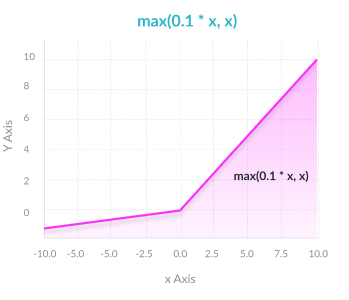

In [6]:
#pip3 install opencv-python

import tensorflow as tf
import scipy.misc
import scipy
import model
import cv2
from subprocess import call
import math

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0


#read data.txt
xs = []
ys = []
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


i = math.ceil(num_images*0.8)
print("Starting frameofvideo:" +str(i))

while(cv2.waitKey(10) != ord('q')):
    full_image = scipy.misc.imread("driving_dataset/" + str(i) + ".jpg", mode="RGB")
    image = scipy.misc.imresize(full_image[-150:], [66, 200]) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180.0 / scipy.pi
    #call("clear")
    #print("Predicted Steering angle: " + str(degrees))
    print("Steering angle: " + str(degrees) + " (pred)\t" + str(ys[i]*180/scipy.pi) + " (actual)")
    cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)
    i += 1

cv2.destroyAllWindows()


W0721 06:32:07.640271 140574809225024 deprecation.py:323] From /home/jupyter/.local/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Starting frameofvideo:36325
Steering angle: 2.6085269374296787 (pred)	-10.79 (actual)
Steering angle: 2.6085269374296787 (pred)	-10.08 (actual)
Steering angle: 2.6085269374296787 (pred)	-9.380000000000003 (actual)
Steering angle: 2.6085269374296787 (pred)	-7.559999999999999 (actual)
Steering angle: 2.6085269374296787 (pred)	-5.949999999999999 (actual)
Steering angle: 2.6085269374296787 (pred)	-3.23 (actual)
Steering angle: 2.6085269374296787 (pred)	-0.81 (actual)
Steering angle: 2.6085269374296787 (pred)	1.21 (actual)
Steering angle: 2.6085269374296787 (pred)	3.4300000000000006 (actual)
Steering angle: 2.6085269374296787 (pred)	4.44 (actual)
Steering angle: 2.6085269374296787 (pred)	5.340000000000001 (actual)
Steering angle: 2.6085269374296787 (pred)	5.75 (actual)
Steering angle: 2.6085269374296787 (pred)	7.16 (actual)
Steering angle: 2.6085269374296787 (pred)	8.27 (actual)
Steering angle: 2.6085269374296787 (pred)	9.48 (actual)
Steering angle: 2.6085269374296787 (pred)	0.0 (actual)
St

Steering angle: 2.6085269374296787 (pred)	47.7 (actual)
Steering angle: 2.6085269374296787 (pred)	47.7 (actual)
Steering angle: 2.6085269374296787 (pred)	47.8 (actual)
Steering angle: 2.6085269374296787 (pred)	47.7 (actual)
Steering angle: 2.6085269374296787 (pred)	47.7 (actual)
Steering angle: 2.6085269374296787 (pred)	47.7 (actual)
Steering angle: 2.6085269374296787 (pred)	47.7 (actual)
Steering angle: 2.6085269374296787 (pred)	47.7 (actual)
Steering angle: 2.6085269374296787 (pred)	47.7 (actual)
Steering angle: 2.6085269374296787 (pred)	47.7 (actual)
Steering angle: 2.6085269374296787 (pred)	47.8 (actual)
Steering angle: 2.6085269374296787 (pred)	47.8 (actual)
Steering angle: 2.6085269374296787 (pred)	48.0 (actual)
Steering angle: 2.6085269374296787 (pred)	0.0 (actual)
Steering angle: 2.6085269374296787 (pred)	48.5 (actual)
Steering angle: 2.6085269374296787 (pred)	48.71000000000001 (actual)
Steering angle: 2.6085269374296787 (pred)	48.91 (actual)
Steering angle: 2.6085269374296787 

Steering angle: 2.6085269374296787 (pred)	21.68 (actual)
Steering angle: 2.6085269374296787 (pred)	22.08 (actual)
Steering angle: 2.6085269374296787 (pred)	22.39 (actual)
Steering angle: 2.6085269374296787 (pred)	22.89 (actual)
Steering angle: 2.6085269374296787 (pred)	23.5 (actual)
Steering angle: 2.6085269374296787 (pred)	23.9 (actual)
Steering angle: 2.6085269374296787 (pred)	24.200000000000003 (actual)
Steering angle: 2.6085269374296787 (pred)	24.200000000000003 (actual)
Steering angle: 2.6085269374296787 (pred)	24.200000000000003 (actual)
Steering angle: 2.6085269374296787 (pred)	24.200000000000003 (actual)
Steering angle: 2.6085269374296787 (pred)	24.4 (actual)
Steering angle: 2.6085269374296787 (pred)	24.71 (actual)
Steering angle: 2.6085269374296787 (pred)	24.91 (actual)
Steering angle: 2.6085269374296787 (pred)	25.41 (actual)
Steering angle: 2.6085269374296787 (pred)	25.61 (actual)
Steering angle: 2.6085269374296787 (pred)	25.71 (actual)
Steering angle: 2.6085269374296787 (pre

Steering angle: 2.6085269374296787 (pred)	15.030000000000001 (actual)
Steering angle: 2.6085269374296787 (pred)	15.030000000000001 (actual)
Steering angle: 2.6085269374296787 (pred)	15.030000000000001 (actual)
Steering angle: 2.6085269374296787 (pred)	15.230000000000002 (actual)
Steering angle: 2.6085269374296787 (pred)	15.43 (actual)
Steering angle: 2.6085269374296787 (pred)	15.63 (actual)
Steering angle: 2.6085269374296787 (pred)	15.929999999999998 (actual)
Steering angle: 2.6085269374296787 (pred)	16.34 (actual)
Steering angle: 2.6085269374296787 (pred)	16.74 (actual)
Steering angle: 2.6085269374296787 (pred)	17.34 (actual)
Steering angle: 2.6085269374296787 (pred)	17.850000000000005 (actual)
Steering angle: 2.6085269374296787 (pred)	17.95 (actual)
Steering angle: 2.6085269374296787 (pred)	17.95 (actual)
Steering angle: 2.6085269374296787 (pred)	18.05 (actual)
Steering angle: 2.6085269374296787 (pred)	18.05 (actual)
Steering angle: 2.6085269374296787 (pred)	18.05 (actual)
Steering a

Steering angle: 2.6085269374296787 (pred)	-0.5 (actual)
Steering angle: 2.6085269374296787 (pred)	-0.5 (actual)
Steering angle: 2.6085269374296787 (pred)	-0.61 (actual)
Steering angle: 2.6085269374296787 (pred)	-0.71 (actual)
Steering angle: 2.6085269374296787 (pred)	-0.91 (actual)
Steering angle: 2.6085269374296787 (pred)	-1.11 (actual)
Steering angle: 2.6085269374296787 (pred)	-1.21 (actual)
Steering angle: 2.6085269374296787 (pred)	-1.31 (actual)
Steering angle: 2.6085269374296787 (pred)	-1.41 (actual)
Steering angle: 2.6085269374296787 (pred)	-1.41 (actual)
Steering angle: 2.6085269374296787 (pred)	-1.41 (actual)
Steering angle: 2.6085269374296787 (pred)	-1.41 (actual)
Steering angle: 2.6085269374296787 (pred)	-1.51 (actual)
Steering angle: 2.6085269374296787 (pred)	-2.52 (actual)
Steering angle: 2.6085269374296787 (pred)	-3.03 (actual)
Steering angle: 2.6085269374296787 (pred)	-3.13 (actual)
Steering angle: 2.6085269374296787 (pred)	-3.4300000000000006 (actual)
Steering angle: 2.6

Steering angle: 2.6085269374296787 (pred)	-21.38 (actual)
Steering angle: 2.6085269374296787 (pred)	-21.38 (actual)
Steering angle: 2.6085269374296787 (pred)	-21.28 (actual)
Steering angle: 2.6085269374296787 (pred)	-21.079999999999995 (actual)
Steering angle: 2.6085269374296787 (pred)	-20.97 (actual)
Steering angle: 2.6085269374296787 (pred)	-20.77 (actual)
Steering angle: 2.6085269374296787 (pred)	-20.370000000000005 (actual)
Steering angle: 2.6085269374296787 (pred)	-19.76 (actual)
Steering angle: 2.6085269374296787 (pred)	-19.66 (actual)
Steering angle: 2.6085269374296787 (pred)	-19.56 (actual)
Steering angle: 2.6085269374296787 (pred)	-19.56 (actual)
Steering angle: 2.6085269374296787 (pred)	-19.56 (actual)
Steering angle: 2.6085269374296787 (pred)	-19.56 (actual)
Steering angle: 2.6085269374296787 (pred)	-19.56 (actual)
Steering angle: 2.6085269374296787 (pred)	-19.56 (actual)
Steering angle: 2.6085269374296787 (pred)	-19.56 (actual)
Steering angle: 2.6085269374296787 (pred)	-19.

Steering angle: 2.6085269374296787 (pred)	-75.23 (actual)
Steering angle: 2.6085269374296787 (pred)	-75.73000000000002 (actual)
Steering angle: 2.6085269374296787 (pred)	-76.03 (actual)
Steering angle: 2.6085269374296787 (pred)	-76.44 (actual)
Steering angle: 2.6085269374296787 (pred)	-77.24 (actual)
Steering angle: 2.6085269374296787 (pred)	-77.75 (actual)
Steering angle: 2.6085269374296787 (pred)	-77.85 (actual)
Steering angle: 2.6085269374296787 (pred)	-77.85 (actual)
Steering angle: 2.6085269374296787 (pred)	-77.85 (actual)
Steering angle: 2.6085269374296787 (pred)	-77.95 (actual)
Steering angle: 2.6085269374296787 (pred)	-77.85 (actual)
Steering angle: 2.6085269374296787 (pred)	-77.24 (actual)
Steering angle: 2.6085269374296787 (pred)	-76.84 (actual)
Steering angle: 2.6085269374296787 (pred)	-76.44 (actual)
Steering angle: 2.6085269374296787 (pred)	-75.63 (actual)
Steering angle: 2.6085269374296787 (pred)	-74.32 (actual)
Steering angle: 2.6085269374296787 (pred)	-73.61 (actual)
St

Steering angle: 2.6085269374296787 (pred)	0.5 (actual)
Steering angle: 2.6085269374296787 (pred)	1.6100000000000003 (actual)
Steering angle: 2.6085269374296787 (pred)	2.52 (actual)
Steering angle: 2.6085269374296787 (pred)	2.92 (actual)
Steering angle: 2.6085269374296787 (pred)	3.03 (actual)
Steering angle: 2.6085269374296787 (pred)	3.4300000000000006 (actual)
Steering angle: 2.6085269374296787 (pred)	4.03 (actual)
Steering angle: 2.6085269374296787 (pred)	4.24 (actual)
Steering angle: 2.6085269374296787 (pred)	4.24 (actual)
Steering angle: 2.6085269374296787 (pred)	4.24 (actual)
Steering angle: 2.6085269374296787 (pred)	4.24 (actual)
Steering angle: 2.6085269374296787 (pred)	4.34 (actual)
Steering angle: 2.6085269374296787 (pred)	4.34 (actual)
Steering angle: 2.6085269374296787 (pred)	4.24 (actual)
Steering angle: 2.6085269374296787 (pred)	4.24 (actual)
Steering angle: 2.6085269374296787 (pred)	4.13 (actual)
Steering angle: 2.6085269374296787 (pred)	4.34 (actual)
Steering angle: 2.608

Steering angle: 2.6085269374296787 (pred)	5.139999999999999 (actual)
Steering angle: 2.6085269374296787 (pred)	4.84 (actual)
Steering angle: 2.6085269374296787 (pred)	4.64 (actual)
Steering angle: 2.6085269374296787 (pred)	4.64 (actual)
Steering angle: 2.6085269374296787 (pred)	4.44 (actual)
Steering angle: 2.6085269374296787 (pred)	4.13 (actual)
Steering angle: 2.6085269374296787 (pred)	4.03 (actual)
Steering angle: 2.6085269374296787 (pred)	3.7300000000000004 (actual)
Steering angle: 2.6085269374296787 (pred)	3.13 (actual)
Steering angle: 2.6085269374296787 (pred)	2.7200000000000006 (actual)
Steering angle: 2.6085269374296787 (pred)	2.22 (actual)
Steering angle: 2.6085269374296787 (pred)	1.71 (actual)
Steering angle: 2.6085269374296787 (pred)	1.41 (actual)
Steering angle: 2.6085269374296787 (pred)	1.21 (actual)
Steering angle: 2.6085269374296787 (pred)	1.21 (actual)
Steering angle: 2.6085269374296787 (pred)	1.21 (actual)
Steering angle: 2.6085269374296787 (pred)	0.0 (actual)
Steering

Steering angle: 2.6085269374296787 (pred)	-6.96 (actual)
Steering angle: 2.6085269374296787 (pred)	-6.45 (actual)
Steering angle: 2.6085269374296787 (pred)	-5.05 (actual)
Steering angle: 2.6085269374296787 (pred)	-5.949999999999999 (actual)
Steering angle: 2.6085269374296787 (pred)	-5.949999999999999 (actual)
Steering angle: 2.6085269374296787 (pred)	-5.949999999999999 (actual)
Steering angle: 2.6085269374296787 (pred)	-5.65 (actual)
Steering angle: 2.6085269374296787 (pred)	-5.340000000000001 (actual)
Steering angle: 2.6085269374296787 (pred)	-5.04 (actual)
Steering angle: 2.6085269374296787 (pred)	-4.44 (actual)
Steering angle: 2.6085269374296787 (pred)	-3.4300000000000006 (actual)
Steering angle: 2.6085269374296787 (pred)	-2.7200000000000006 (actual)
Steering angle: 2.6085269374296787 (pred)	-2.12 (actual)
Steering angle: 2.6085269374296787 (pred)	-1.51 (actual)
Steering angle: 2.6085269374296787 (pred)	-0.81 (actual)
Steering angle: 2.6085269374296787 (pred)	0.2 (actual)
Steering a

Steering angle: 2.6085269374296787 (pred)	10.99 (actual)
Steering angle: 2.6085269374296787 (pred)	11.089999999999998 (actual)
Steering angle: 2.6085269374296787 (pred)	11.19 (actual)
Steering angle: 2.6085269374296787 (pred)	11.6 (actual)
Steering angle: 2.6085269374296787 (pred)	12.0 (actual)
Steering angle: 2.6085269374296787 (pred)	12.4 (actual)
Steering angle: 2.6085269374296787 (pred)	12.61 (actual)
Steering angle: 2.6085269374296787 (pred)	12.81 (actual)
Steering angle: 2.6085269374296787 (pred)	12.81 (actual)
Steering angle: 2.6085269374296787 (pred)	12.81 (actual)
Steering angle: 2.6085269374296787 (pred)	12.81 (actual)
Steering angle: 2.6085269374296787 (pred)	12.709999999999999 (actual)
Steering angle: 2.6085269374296787 (pred)	12.61 (actual)
Steering angle: 2.6085269374296787 (pred)	12.4 (actual)
Steering angle: 2.6085269374296787 (pred)	12.2 (actual)
Steering angle: 2.6085269374296787 (pred)	11.5 (actual)
Steering angle: 2.6085269374296787 (pred)	10.389999999999999 (actual

KeyboardInterrupt: 

## Run on Tanh Activation Function

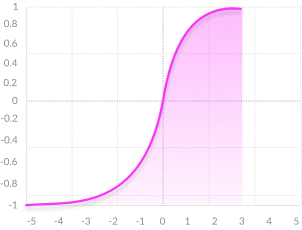

In [9]:
#pip3 install opencv-python
#1.47
import tensorflow as tf
import scipy.misc
import scipy
import model
import cv2
from subprocess import call
import math

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0


#read data.txt
xs = []
ys = []
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


i = math.ceil(num_images*0.8)
print("Starting frameofvideo:" +str(i))

while(cv2.waitKey(10) != ord('q')):
    full_image = scipy.misc.imread("driving_dataset/" + str(i) + ".jpg", mode="RGB")
    image = scipy.misc.imresize(full_image[-150:], [66, 200]) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180.0 / scipy.pi
    #call("clear")
    #print("Predicted Steering angle: " + str(degrees))
    print("Steering angle: " + str(degrees) + " (pred)\t" + str(ys[i]*180/scipy.pi) + " (actual)")
    cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)
    i += 1

cv2.destroyAllWindows()


/home/jupyter/.local/lib/python3.7/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Starting frameofvideo:36325
Steering angle: 102.33529682476451 (pred)	-10.79 (actual)
Steering angle: 79.08939685259728 (pred)	-10.08 (actual)
Steering angle: 71.68597039611286 (pred)	-9.380000000000003 (actual)


/home/jupyter/.local/lib/python3.7/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/jupyter/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Steering angle: 110.31730860584071 (pred)	-7.559999999999999 (actual)
Steering angle: 120.18769693769617 (pred)	-5.949999999999999 (actual)
Steering angle: 122.37526992506785 (pred)	-3.23 (actual)
Steering angle: 89.13135953640345 (pred)	-0.81 (actual)
Steering angle: 68.8238274357432 (pred)	1.21 (actual)
Steering angle: 60.18093338076575 (pred)	3.4300000000000006 (actual)
Steering angle: 24.59345360672845 (pred)	4.44 (actual)
Steering angle: 16.191728408702268 (pred)	5.340000000000001 (actual)
Steering angle: 13.410903973043494 (pred)	5.75 (actual)
Steering angle: 7.009098291358419 (pred)	7.16 (actual)
Steering angle: 6.1522617321508974 (pred)	8.27 (actual)
Steering angle: 5.136610468135886 (pred)	9.48 (actual)
Steering angle: 4.127585768276256 (pred)	0.0 (actual)
Steering angle: 3.2850751039660127 (pred)	9.88 (actual)
Steering angle: 4.031735589219351 (pred)	9.979999999999999 (actual)
Steering angle: 4.827481655829809 (pred)	10.389999999999999 (actual)
Steering angle: 5.2937500690494

Steering angle: 29.651845602262995 (pred)	47.7 (actual)
Steering angle: 30.740471888030893 (pred)	47.7 (actual)
Steering angle: 27.894690645818006 (pred)	47.7 (actual)
Steering angle: 25.472821679347373 (pred)	47.7 (actual)
Steering angle: 23.539714219693685 (pred)	47.7 (actual)
Steering angle: 24.52740567745443 (pred)	47.7 (actual)
Steering angle: 26.588551863289176 (pred)	47.8 (actual)
Steering angle: 26.608900704373934 (pred)	47.8 (actual)
Steering angle: 27.413512356527068 (pred)	48.0 (actual)
Steering angle: 40.444357283394375 (pred)	0.0 (actual)
Steering angle: 47.747905883645686 (pred)	48.5 (actual)
Steering angle: 65.92674122757977 (pred)	48.71000000000001 (actual)
Steering angle: 85.2961400155496 (pred)	48.91 (actual)
Steering angle: 96.69571891011171 (pred)	49.11 (actual)
Steering angle: 98.8782307273084 (pred)	49.21 (actual)
Steering angle: 95.84801730203226 (pred)	49.41 (actual)
Steering angle: 102.17224654889797 (pred)	49.92 (actual)
Steering angle: 99.03682088964693 (pred

Steering angle: 8.733563108662082 (pred)	24.200000000000003 (actual)
Steering angle: 8.940441854658951 (pred)	24.200000000000003 (actual)
Steering angle: 8.426407794139315 (pred)	24.200000000000003 (actual)
Steering angle: 8.510268002995087 (pred)	24.4 (actual)
Steering angle: 7.360530307175792 (pred)	24.71 (actual)
Steering angle: 6.75264645925242 (pred)	24.91 (actual)
Steering angle: 7.127335696080509 (pred)	25.41 (actual)
Steering angle: 7.626485066851395 (pred)	25.61 (actual)
Steering angle: 7.747956566145487 (pred)	25.71 (actual)
Steering angle: 9.115189683252789 (pred)	25.820000000000004 (actual)
Steering angle: 11.346199258651168 (pred)	26.12 (actual)
Steering angle: 10.606827865902703 (pred)	26.520000000000003 (actual)
Steering angle: 9.32596761349209 (pred)	26.82 (actual)
Steering angle: 10.161245961244935 (pred)	27.03 (actual)
Steering angle: 9.659390128015433 (pred)	27.43 (actual)
Steering angle: 11.869794730235176 (pred)	27.73 (actual)
Steering angle: 12.745051028973753 (pr

Steering angle: 24.90199715720002 (pred)	17.34 (actual)
Steering angle: 23.836878675008016 (pred)	17.850000000000005 (actual)
Steering angle: 21.13825215091576 (pred)	17.95 (actual)
Steering angle: 14.77068364621902 (pred)	17.95 (actual)
Steering angle: 14.882142088189873 (pred)	18.05 (actual)
Steering angle: 15.964098694233252 (pred)	18.05 (actual)
Steering angle: 13.901997989461995 (pred)	18.05 (actual)
Steering angle: 14.014510841885969 (pred)	18.05 (actual)
Steering angle: 13.326557966983007 (pred)	18.05 (actual)
Steering angle: 11.267480474693127 (pred)	18.05 (actual)
Steering angle: 9.865298133376514 (pred)	17.95 (actual)
Steering angle: 8.986912754224425 (pred)	17.75 (actual)
Steering angle: 8.292768312838847 (pred)	17.04 (actual)
Steering angle: 7.019260332182928 (pred)	16.03 (actual)
Steering angle: 6.8380575479366055 (pred)	15.230000000000002 (actual)
Steering angle: 6.681670548492232 (pred)	14.32 (actual)
Steering angle: 6.354247501381099 (pred)	13.92 (actual)
Steering angle

Steering angle: 2.3944779869081763 (pred)	-1.41 (actual)
Steering angle: 2.7433898763652267 (pred)	-1.41 (actual)
Steering angle: 3.113697333397342 (pred)	-1.51 (actual)
Steering angle: 3.202128432911732 (pred)	-2.52 (actual)
Steering angle: 2.8845632697636314 (pred)	-3.03 (actual)
Steering angle: 2.750970746013706 (pred)	-3.13 (actual)
Steering angle: 2.398961365768055 (pred)	-3.4300000000000006 (actual)
Steering angle: 1.8278247893529966 (pred)	-3.4300000000000006 (actual)
Steering angle: -0.7729923586076184 (pred)	-3.4300000000000006 (actual)
Steering angle: -1.096222203176892 (pred)	-3.4300000000000006 (actual)
Steering angle: -1.7597726264443978 (pred)	-4.13 (actual)
Steering angle: -3.7052205303810073 (pred)	-4.44 (actual)
Steering angle: -2.9060533927700187 (pred)	-4.54 (actual)
Steering angle: -2.0146417756536583 (pred)	-4.74 (actual)
Steering angle: -3.4639319316758477 (pred)	-5.75 (actual)
Steering angle: -1.256038597914847 (pred)	-6.76 (actual)
Steering angle: -2.21387199044

Steering angle: -5.727858109675223 (pred)	-19.66 (actual)
Steering angle: -5.578061389006265 (pred)	-19.56 (actual)
Steering angle: -5.1905488988982995 (pred)	-19.56 (actual)
Steering angle: -4.96850286407577 (pred)	-19.56 (actual)
Steering angle: -4.979288586548866 (pred)	-19.56 (actual)
Steering angle: -4.890807327832759 (pred)	-19.56 (actual)
Steering angle: -5.125215151279366 (pred)	-19.56 (actual)
Steering angle: -5.835154832007423 (pred)	-19.56 (actual)
Steering angle: -6.543313967796222 (pred)	-19.46 (actual)
Steering angle: -5.907854511759393 (pred)	-19.46 (actual)
Steering angle: -4.462484457433967 (pred)	-19.46 (actual)
Steering angle: -4.3665561580884305 (pred)	-19.46 (actual)
Steering angle: -4.5696270736230185 (pred)	-19.36 (actual)
Steering angle: -5.731998058085897 (pred)	-19.36 (actual)
Steering angle: -7.172521666308375 (pred)	-19.36 (actual)
Steering angle: -7.664011833698738 (pred)	-19.87 (actual)
Steering angle: -8.199153740074651 (pred)	-20.97 (actual)
Steering ang

Steering angle: -41.6486835586077 (pred)	-77.85 (actual)
Steering angle: -44.705961608470034 (pred)	-77.85 (actual)
Steering angle: -46.17631692166619 (pred)	-77.85 (actual)
Steering angle: -47.73025667483038 (pred)	-77.95 (actual)
Steering angle: -46.068167706348206 (pred)	-77.85 (actual)
Steering angle: -47.04422222931054 (pred)	-77.24 (actual)
Steering angle: -49.451775119280825 (pred)	-76.84 (actual)
Steering angle: -51.15186726030495 (pred)	-76.44 (actual)
Steering angle: -54.90798636038089 (pred)	-75.63 (actual)
Steering angle: -54.266863823748466 (pred)	-74.32 (actual)
Steering angle: -55.1178951490483 (pred)	-73.61 (actual)
Steering angle: -55.772029196049594 (pred)	-72.5 (actual)
Steering angle: -54.67524424931812 (pred)	-71.7 (actual)
Steering angle: -53.58874215238209 (pred)	-70.08 (actual)
Steering angle: -51.496627888850504 (pred)	-69.07999999999998 (actual)
Steering angle: -50.639090808366234 (pred)	-68.97 (actual)
Steering angle: -48.51420188210234 (pred)	-68.97 (actual)

Steering angle: 7.045689322289469 (pred)	3.4300000000000006 (actual)
Steering angle: 7.242670270405345 (pred)	4.03 (actual)
Steering angle: 6.956025160186481 (pred)	4.24 (actual)
Steering angle: 7.023886504685143 (pred)	4.24 (actual)
Steering angle: 7.1484179287274 (pred)	4.24 (actual)
Steering angle: 6.891116591843381 (pred)	4.24 (actual)
Steering angle: 6.8086245552557285 (pred)	4.34 (actual)
Steering angle: 6.89156994564954 (pred)	4.34 (actual)
Steering angle: 6.918799775436265 (pred)	4.24 (actual)
Steering angle: 6.920380964229123 (pred)	4.24 (actual)
Steering angle: 6.932359408486033 (pred)	4.13 (actual)
Steering angle: 6.7787501615997385 (pred)	4.34 (actual)
Steering angle: 6.540290755314845 (pred)	4.74 (actual)
Steering angle: 6.510984121133613 (pred)	5.24 (actual)
Steering angle: 6.650554767954593 (pred)	5.75 (actual)
Steering angle: 6.685174435536449 (pred)	5.75 (actual)
Steering angle: 6.478461321626951 (pred)	5.849999999999999 (actual)
Steering angle: 6.632397136932937 (pred

Steering angle: 117.60061252539211 (pred)	3.7300000000000004 (actual)
Steering angle: 106.60791482987682 (pred)	3.13 (actual)
Steering angle: 103.52301891010555 (pred)	2.7200000000000006 (actual)
Steering angle: 112.00372329305188 (pred)	2.22 (actual)
Steering angle: 106.65486555023149 (pred)	1.71 (actual)
Steering angle: 103.12230537187924 (pred)	1.41 (actual)
Steering angle: 108.93612141225907 (pred)	1.21 (actual)
Steering angle: 71.85088531362281 (pred)	1.21 (actual)
Steering angle: 45.214079871394794 (pred)	1.21 (actual)
Steering angle: 37.16401891561777 (pred)	0.0 (actual)
Steering angle: 10.603672318506158 (pred)	0.91 (actual)
Steering angle: 7.11290051815651 (pred)	0.61 (actual)
Steering angle: 9.308372192416492 (pred)	0.4 (actual)
Steering angle: 8.571307696060197 (pred)	0.4 (actual)
Steering angle: 9.518664325451075 (pred)	0.4 (actual)
Steering angle: 7.6029046925155725 (pred)	1.41 (actual)
Steering angle: 6.739172203567277 (pred)	2.32 (actual)
Steering angle: 6.15078982638475

Steering angle: 6.44680040661618 (pred)	-5.949999999999999 (actual)
Steering angle: 6.273702495593724 (pred)	-5.65 (actual)
Steering angle: 6.608152953587154 (pred)	-5.340000000000001 (actual)
Steering angle: 6.539276472223099 (pred)	-5.04 (actual)
Steering angle: 6.150105099920466 (pred)	-4.44 (actual)
Steering angle: 6.1197696684955005 (pred)	-3.4300000000000006 (actual)
Steering angle: 6.129232895590553 (pred)	-2.7200000000000006 (actual)
Steering angle: 6.50377699089878 (pred)	-2.12 (actual)
Steering angle: 6.613737487007285 (pred)	-1.51 (actual)
Steering angle: 6.6421480857467765 (pred)	-0.81 (actual)
Steering angle: 6.676000210820652 (pred)	0.2 (actual)
Steering angle: 6.715849668872622 (pred)	1.11 (actual)
Steering angle: 6.8282297594946035 (pred)	1.51 (actual)
Steering angle: 6.7797742630884175 (pred)	1.6100000000000003 (actual)
Steering angle: 6.830444875219803 (pred)	1.82 (actual)
Steering angle: 6.8855521221039355 (pred)	2.12 (actual)
Steering angle: 6.917596808368697 (pred)

Steering angle: 9.434492489214422 (pred)	12.81 (actual)
Steering angle: 9.433966564648331 (pred)	12.709999999999999 (actual)
Steering angle: 9.156282662620525 (pred)	12.61 (actual)
Steering angle: 8.747956878564237 (pred)	12.4 (actual)
Steering angle: 8.083588646865328 (pred)	12.2 (actual)
Steering angle: 8.210869222048515 (pred)	11.5 (actual)
Steering angle: 9.268972246189273 (pred)	10.389999999999999 (actual)
Steering angle: 9.260156179518079 (pred)	9.68 (actual)
Steering angle: 8.446793347490866 (pred)	9.380000000000003 (actual)
Steering angle: 7.688997519456291 (pred)	8.77 (actual)
Steering angle: 6.990209403208748 (pred)	8.37 (actual)
Steering angle: 6.993356412868832 (pred)	7.969999999999999 (actual)
Steering angle: 6.8845766857130934 (pred)	7.559999999999999 (actual)
Steering angle: 6.801920724585361 (pred)	7.06 (actual)
Steering angle: 6.764872070979919 (pred)	6.25 (actual)
Steering angle: 6.769767182180702 (pred)	5.340000000000001 (actual)
Steering angle: 6.724932539808269 (pr

Steering angle: 3.433345063912061 (pred)	-8.87 (actual)
Steering angle: 3.4265095386567594 (pred)	-8.87 (actual)
Steering angle: 3.1344004905452967 (pred)	-8.87 (actual)
Steering angle: 3.0907677480233744 (pred)	-8.87 (actual)
Steering angle: 2.853271184968041 (pred)	-8.77 (actual)
Steering angle: 2.3291613147621675 (pred)	-8.77 (actual)
Steering angle: 2.4342512456622183 (pred)	-8.87 (actual)
Steering angle: 2.4322875662758396 (pred)	-8.87 (actual)
Steering angle: 2.6104095083196635 (pred)	-8.87 (actual)
Steering angle: 3.600712232777465 (pred)	-8.87 (actual)
Steering angle: 4.215541102426272 (pred)	-8.87 (actual)
Steering angle: 3.978719660881712 (pred)	-8.87 (actual)
Steering angle: 3.791247616750964 (pred)	-8.87 (actual)
Steering angle: 4.007428653510568 (pred)	-8.87 (actual)
Steering angle: 4.071335318479792 (pred)	-8.97 (actual)
Steering angle: 4.2130715621544885 (pred)	-8.97 (actual)
Steering angle: 4.26804348591569 (pred)	0.0 (actual)
Steering angle: 4.238924681936633 (pred)	-9

Steering angle: 1.88286117302449 (pred)	-1.92 (actual)
Steering angle: 2.1610771894773233 (pred)	-1.92 (actual)
Steering angle: 2.2330116745988398 (pred)	-1.92 (actual)
Steering angle: 2.389478288435727 (pred)	-1.92 (actual)
Steering angle: 1.9081926371087747 (pred)	-2.12 (actual)
Steering angle: 1.9520533371942463 (pred)	-2.22 (actual)
Steering angle: 2.2099350267143056 (pred)	-2.22 (actual)
Steering angle: 2.707460306566609 (pred)	-1.82 (actual)
Steering angle: 2.7568380919541586 (pred)	-1.82 (actual)
Steering angle: 2.977451921485101 (pred)	-1.82 (actual)
Steering angle: 2.8522925469260256 (pred)	-1.71 (actual)
Steering angle: 3.0659871813843336 (pred)	-1.21 (actual)
Steering angle: 2.972624471845783 (pred)	-0.91 (actual)
Steering angle: 3.1278738179065266 (pred)	-0.91 (actual)
Steering angle: 3.1017195294706665 (pred)	-0.81 (actual)
Steering angle: 3.3010519836517305 (pred)	-0.81 (actual)
Steering angle: 3.4992911806787688 (pred)	-0.61 (actual)
Steering angle: 3.305105700924133 (pr

Steering angle: 5.0495434854647945 (pred)	21.28 (actual)
Steering angle: 5.877472976557529 (pred)	22.179999999999996 (actual)
Steering angle: 5.606263666976071 (pred)	23.09 (actual)
Steering angle: 5.529716029400445 (pred)	24.1 (actual)
Steering angle: 5.857649633152037 (pred)	24.810000000000002 (actual)
Steering angle: 4.821639282768509 (pred)	25.11 (actual)
Steering angle: 4.907594652152182 (pred)	25.31 (actual)
Steering angle: 4.6590269927824925 (pred)	25.71 (actual)
Steering angle: 5.339668150178957 (pred)	26.520000000000003 (actual)
Steering angle: 4.208319031152629 (pred)	27.23 (actual)
Steering angle: 4.688588905283954 (pred)	27.93 (actual)
Steering angle: 4.833300123229014 (pred)	28.44 (actual)
Steering angle: 4.516083513171996 (pred)	28.64 (actual)
Steering angle: 3.2588584900539765 (pred)	28.64 (actual)
Steering angle: 2.3534027233436006 (pred)	28.64 (actual)
Steering angle: 1.1783061359616358 (pred)	28.64 (actual)
Steering angle: -1.5506545388951156 (pred)	28.54 (actual)
Ste

Steering angle: 21.57231238021736 (pred)	68.17 (actual)
Steering angle: 18.87773274320834 (pred)	66.55 (actual)
Steering angle: 44.915689397124446 (pred)	65.45 (actual)
Steering angle: 36.91531806755926 (pred)	62.620000000000005 (actual)
Steering angle: 15.354318188154732 (pred)	59.38999999999999 (actual)
Steering angle: 17.61211918057249 (pred)	54.35 (actual)
Steering angle: 23.28208460684268 (pred)	51.43 (actual)
Steering angle: 15.533793361427865 (pred)	49.41 (actual)
Steering angle: 17.82036140308242 (pred)	46.59 (actual)
Steering angle: 13.975900636281533 (pred)	44.47 (actual)
Steering angle: 9.106962720397508 (pred)	42.25 (actual)
Steering angle: 9.492404809413316 (pred)	39.53 (actual)
Steering angle: 7.994762890482959 (pred)	37.61 (actual)
Steering angle: 10.704923042762427 (pred)	35.70000000000001 (actual)
Steering angle: 12.788749725509849 (pred)	34.49 (actual)
Steering angle: 15.88120922601327 (pred)	33.58 (actual)
Steering angle: 12.71779259776988 (pred)	32.87 (actual)
Steer

Steering angle: 2.2710611643611003 (pred)	0.0 (actual)
Steering angle: 2.1179776285974854 (pred)	59.19 (actual)
Steering angle: 1.722839659168023 (pred)	57.18 (actual)
Steering angle: 1.2899863456371028 (pred)	54.15 (actual)
Steering angle: 1.1453069307603654 (pred)	51.93 (actual)
Steering angle: 0.7844776418621122 (pred)	50.22 (actual)
Steering angle: 0.6707950128210679 (pred)	0.0 (actual)
Steering angle: 0.4535738663169177 (pred)	46.89 (actual)
Steering angle: -0.10294287694271323 (pred)	43.76 (actual)
Steering angle: -0.22881787389990627 (pred)	39.33 (actual)
Steering angle: -0.24635515832628094 (pred)	35.09000000000001 (actual)
Steering angle: -0.3123267015393912 (pred)	30.66 (actual)
Steering angle: -0.5828064882205538 (pred)	26.12 (actual)
Steering angle: -0.4579574603818907 (pred)	20.370000000000005 (actual)
Steering angle: -0.47755295294553995 (pred)	14.52 (actual)
Steering angle: -0.45663074949646865 (pred)	11.39 (actual)
Steering angle: -0.3775407607652911 (pred)	6.76 (actual

Steering angle: 0.8730793360231935 (pred)	8.27 (actual)
Steering angle: 0.7839197541451396 (pred)	8.27 (actual)
Steering angle: 0.8698053275332303 (pred)	8.27 (actual)
Steering angle: 0.8698189879115703 (pred)	8.27 (actual)
Steering angle: 0.9103533325103927 (pred)	8.27 (actual)
Steering angle: 0.9532999611858463 (pred)	8.27 (actual)
Steering angle: 0.9694351091612378 (pred)	8.27 (actual)
Steering angle: 0.9561137856804799 (pred)	0.0 (actual)
Steering angle: 1.021850727903856 (pred)	8.27 (actual)
Steering angle: 0.9713500167280743 (pred)	8.27 (actual)
Steering angle: 0.9949628344624546 (pred)	8.27 (actual)
Steering angle: 0.856002742520251 (pred)	8.27 (actual)
Steering angle: 0.8595666071631167 (pred)	8.27 (actual)
Steering angle: 0.8015945761698401 (pred)	8.27 (actual)
Steering angle: 0.8626114307899143 (pred)	8.27 (actual)
Steering angle: 0.7812962144519142 (pred)	8.27 (actual)
Steering angle: 0.7855751145235157 (pred)	8.27 (actual)
Steering angle: 0.7086739079366363 (pred)	8.27 (act

IndexError: too many indices for array

## On using Linear Activation function

In [5]:
#pip3 install opencv-python

import tensorflow as tf
import scipy.misc
import scipy
import model
import cv2
from subprocess import call
import math

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0


#read data.txt
xs = []
ys = []
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


i = math.ceil(num_images*0.8)
print("Starting frameofvideo:" +str(i))

while(cv2.waitKey(10) != ord('q')):
    full_image = scipy.misc.imread("driving_dataset/" + str(i) + ".jpg", mode="RGB")
    image = scipy.misc.imresize(full_image[-150:], [66, 200]) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 0.5})[0][0] * 180.0 / scipy.pi
    #call("clear")
    #print("Predicted Steering angle: " + str(degrees))
    print("Steering angle: " + str(degrees) + " (pred)\t" + str(ys[i]*180/scipy.pi) + " (actual)")
    cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)
    i += 1

cv2.destroyAllWindows()


Starting frameofvideo:36325
Steering angle: 6.379324540918801 (pred)	-10.79 (actual)
Steering angle: 6.459139997125455 (pred)	-10.08 (actual)
Steering angle: 9.357081686482436 (pred)	-9.380000000000003 (actual)
Steering angle: 11.0267905847574 (pred)	-7.559999999999999 (actual)
Steering angle: 16.57762726661882 (pred)	-5.949999999999999 (actual)


/home/jupyter/.local/lib/python3.7/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/jupyter/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Steering angle: 3.079593771984645 (pred)	-3.23 (actual)
Steering angle: 1.0630973865279167 (pred)	-0.81 (actual)
Steering angle: 8.406503769124253 (pred)	1.21 (actual)
Steering angle: 7.738726419255861 (pred)	3.4300000000000006 (actual)
Steering angle: 9.190380674504521 (pred)	4.44 (actual)
Steering angle: 7.874039296902984 (pred)	5.340000000000001 (actual)
Steering angle: 13.684700643659918 (pred)	5.75 (actual)
Steering angle: 2.8175834465547247 (pred)	7.16 (actual)
Steering angle: 16.850909965500197 (pred)	8.27 (actual)
Steering angle: 7.020514098782448 (pred)	9.48 (actual)
Steering angle: 3.2149429350117336 (pred)	0.0 (actual)
Steering angle: -0.2950524327569149 (pred)	9.88 (actual)
Steering angle: 4.887996704989299 (pred)	9.979999999999999 (actual)
Steering angle: 2.0023043195784997 (pred)	10.389999999999999 (actual)
Steering angle: 3.786227854597828 (pred)	11.6 (actual)
Steering angle: 1.619051733078506 (pred)	11.39 (actual)
Steering angle: 2.504736876906046 (pred)	10.89 (actual)


Steering angle: 12.800166386707525 (pred)	47.7 (actual)
Steering angle: 10.919780303483519 (pred)	47.7 (actual)
Steering angle: 25.318766762617738 (pred)	47.7 (actual)
Steering angle: 45.42292656564627 (pred)	47.7 (actual)
Steering angle: 7.197970951155843 (pred)	47.7 (actual)
Steering angle: 33.58763624355071 (pred)	47.7 (actual)
Steering angle: 31.98456693968662 (pred)	47.7 (actual)
Steering angle: 16.258005149313487 (pred)	47.8 (actual)
Steering angle: 31.14028384128676 (pred)	47.8 (actual)
Steering angle: 17.453192631417338 (pred)	48.0 (actual)
Steering angle: 47.08345142080851 (pred)	0.0 (actual)
Steering angle: 12.49632286015857 (pred)	48.5 (actual)
Steering angle: 52.87501470487244 (pred)	48.71000000000001 (actual)
Steering angle: 34.53512350030946 (pred)	48.91 (actual)
Steering angle: 24.968598331796816 (pred)	49.11 (actual)
Steering angle: 21.81041960487318 (pred)	49.21 (actual)
Steering angle: 17.400344042714362 (pred)	49.41 (actual)
Steering angle: 19.268021705213915 (pred)	

Steering angle: 5.946572292843256 (pred)	24.200000000000003 (actual)
Steering angle: 4.377415305095105 (pred)	24.4 (actual)
Steering angle: 10.60306357789638 (pred)	24.71 (actual)
Steering angle: 5.096290580804831 (pred)	24.91 (actual)
Steering angle: 3.8265989683476573 (pred)	25.41 (actual)
Steering angle: 13.878307478325807 (pred)	25.61 (actual)
Steering angle: 5.11507957743789 (pred)	25.71 (actual)
Steering angle: 11.1322026017655 (pred)	25.820000000000004 (actual)
Steering angle: 7.2352893972335 (pred)	26.12 (actual)
Steering angle: 6.435322273715974 (pred)	26.520000000000003 (actual)
Steering angle: 9.250613551473924 (pred)	26.82 (actual)
Steering angle: 4.167234589521357 (pred)	27.03 (actual)
Steering angle: 6.2538189611461705 (pred)	27.43 (actual)
Steering angle: 5.261409550216243 (pred)	27.73 (actual)
Steering angle: 0.6892461285336227 (pred)	28.13 (actual)
Steering angle: 4.792829544849396 (pred)	28.44 (actual)
Steering angle: 7.79923591888665 (pred)	28.840000000000003 (actual

Steering angle: 12.687841364485726 (pred)	17.34 (actual)
Steering angle: 6.111377927326494 (pred)	17.850000000000005 (actual)
Steering angle: 6.747741102767881 (pred)	17.95 (actual)
Steering angle: 11.988517932161985 (pred)	17.95 (actual)
Steering angle: 8.425046025173545 (pred)	18.05 (actual)
Steering angle: 13.219121652659645 (pred)	18.05 (actual)
Steering angle: 9.955009253030047 (pred)	18.05 (actual)
Steering angle: 4.2771784370437596 (pred)	18.05 (actual)
Steering angle: 10.781686685070554 (pred)	18.05 (actual)
Steering angle: 6.157611050931487 (pred)	18.05 (actual)
Steering angle: 2.8991367590183232 (pred)	17.95 (actual)
Steering angle: 5.001585739094373 (pred)	17.75 (actual)
Steering angle: 6.839682279185422 (pred)	17.04 (actual)
Steering angle: 9.099875545359975 (pred)	16.03 (actual)
Steering angle: 7.416461872515381 (pred)	15.230000000000002 (actual)
Steering angle: 2.11560883361596 (pred)	14.32 (actual)
Steering angle: 4.87922375388724 (pred)	13.92 (actual)
Steering angle: 5.

Steering angle: 1.6629378329299536 (pred)	-1.41 (actual)
Steering angle: 0.6886037172256713 (pred)	-1.41 (actual)
Steering angle: 3.1702233386381327 (pred)	-1.51 (actual)
Steering angle: 3.157298486294353 (pred)	-2.52 (actual)
Steering angle: 3.8540170552233812 (pred)	-3.03 (actual)
Steering angle: -0.1912263403173676 (pred)	-3.13 (actual)
Steering angle: -0.8938803036144972 (pred)	-3.4300000000000006 (actual)
Steering angle: -5.959197470637201 (pred)	-3.4300000000000006 (actual)
Steering angle: -6.2204923337515625 (pred)	-3.4300000000000006 (actual)
Steering angle: 3.416101824465541 (pred)	-3.4300000000000006 (actual)
Steering angle: -0.6046838509363691 (pred)	-4.13 (actual)
Steering angle: 0.9464774559786497 (pred)	-4.44 (actual)
Steering angle: -6.783027567567459 (pred)	-4.54 (actual)
Steering angle: -1.3410907815024902 (pred)	-4.74 (actual)
Steering angle: -13.446394489744526 (pred)	-5.75 (actual)
Steering angle: -0.1758302801751523 (pred)	-6.76 (actual)
Steering angle: 0.951888780

Steering angle: 1.1510910337703084 (pred)	-19.56 (actual)
Steering angle: -20.236259076671168 (pred)	-19.56 (actual)
Steering angle: -23.69986337271027 (pred)	-19.56 (actual)
Steering angle: 0.9367856309898133 (pred)	-19.56 (actual)
Steering angle: -25.502958181512764 (pred)	-19.56 (actual)
Steering angle: -2.077542268380775 (pred)	-19.56 (actual)
Steering angle: -16.9476886233974 (pred)	-19.46 (actual)
Steering angle: -29.884403298218174 (pred)	-19.46 (actual)
Steering angle: -5.329563312188745 (pred)	-19.46 (actual)
Steering angle: -7.992105093122178 (pred)	-19.46 (actual)
Steering angle: -7.3207871439427805 (pred)	-19.36 (actual)
Steering angle: -13.7884196275275 (pred)	-19.36 (actual)
Steering angle: -26.137726934669775 (pred)	-19.36 (actual)
Steering angle: -27.309602981136372 (pred)	-19.87 (actual)
Steering angle: -14.82341441415881 (pred)	-20.97 (actual)
Steering angle: -18.31648926891922 (pred)	-22.29 (actual)
Steering angle: -17.78666124971758 (pred)	-24.200000000000003 (actua

Steering angle: -51.2381564551843 (pred)	-76.84 (actual)
Steering angle: -44.15108045539279 (pred)	-76.44 (actual)
Steering angle: -115.49556188357252 (pred)	-75.63 (actual)
Steering angle: -89.8397594363605 (pred)	-74.32 (actual)
Steering angle: -59.175707119858295 (pred)	-73.61 (actual)
Steering angle: -61.006778383501164 (pred)	-72.5 (actual)
Steering angle: -31.69518548493152 (pred)	-71.7 (actual)
Steering angle: -46.910504200834616 (pred)	-70.08 (actual)
Steering angle: -125.11297366894905 (pred)	-69.07999999999998 (actual)
Steering angle: -71.22991183504193 (pred)	-68.97 (actual)
Steering angle: -60.12207081049858 (pred)	-68.97 (actual)
Steering angle: -79.3250383789627 (pred)	-68.37 (actual)
Steering angle: -87.70706701896987 (pred)	-67.16 (actual)
Steering angle: -41.01102392788448 (pred)	-65.14 (actual)
Steering angle: -63.784145035892614 (pred)	-64.03 (actual)
Steering angle: -38.10521556815094 (pred)	-63.32999999999999 (actual)
Steering angle: -65.71264211785655 (pred)	-63.2

Steering angle: 0.9517794970435779 (pred)	4.24 (actual)
Steering angle: 2.6492246195991993 (pred)	4.24 (actual)
Steering angle: 0.4581563896414673 (pred)	4.13 (actual)
Steering angle: 1.200809154677595 (pred)	4.34 (actual)
Steering angle: 3.506350821516212 (pred)	4.74 (actual)
Steering angle: -1.262727060659582 (pred)	5.24 (actual)
Steering angle: 0.7871549692950514 (pred)	5.75 (actual)
Steering angle: -5.443472938297988 (pred)	5.75 (actual)
Steering angle: 3.155790081704838 (pred)	5.849999999999999 (actual)
Steering angle: 1.709505849247689 (pred)	5.849999999999999 (actual)
Steering angle: 0.47425658625821543 (pred)	5.849999999999999 (actual)
Steering angle: 2.221839832994226 (pred)	5.55 (actual)
Steering angle: 3.6897907061591253 (pred)	5.24 (actual)
Steering angle: -1.4850048950270687 (pred)	4.84 (actual)
Steering angle: 1.570420892909721 (pred)	4.84 (actual)
Steering angle: 0.10397850437561641 (pred)	4.84 (actual)
Steering angle: 2.200650665198143 (pred)	4.74 (actual)
Steering angl

Steering angle: 12.529929098422324 (pred)	0.91 (actual)
Steering angle: 5.639016131593575 (pred)	0.61 (actual)
Steering angle: 7.153496174375305 (pred)	0.4 (actual)
Steering angle: 7.285995867858028 (pred)	0.4 (actual)
Steering angle: 6.572909604356711 (pred)	0.4 (actual)
Steering angle: 3.8625812586689308 (pred)	1.41 (actual)
Steering angle: 1.4977607001888906 (pred)	2.32 (actual)
Steering angle: 3.153345087425385 (pred)	3.23 (actual)
Steering angle: 1.387464671037409 (pred)	3.9300000000000006 (actual)
Steering angle: 9.397080981809324 (pred)	4.13 (actual)
Steering angle: 0.3562960976822011 (pred)	4.24 (actual)
Steering angle: 4.951410742564636 (pred)	4.24 (actual)
Steering angle: 2.156407047632327 (pred)	4.24 (actual)
Steering angle: 2.4480381959453004 (pred)	4.24 (actual)
Steering angle: 0.6660853305840797 (pred)	4.24 (actual)
Steering angle: 0.18837644388617977 (pred)	3.7300000000000004 (actual)
Steering angle: 0.37984634981656706 (pred)	3.23 (actual)
Steering angle: 2.624460061216

Steering angle: 5.35630136835523 (pred)	-2.7200000000000006 (actual)
Steering angle: 3.6110744835220205 (pred)	-2.12 (actual)
Steering angle: 3.99603632486181 (pred)	-1.51 (actual)
Steering angle: 1.4698563892216268 (pred)	-0.81 (actual)
Steering angle: -1.0259421179383994 (pred)	0.2 (actual)
Steering angle: 2.393083987987259 (pred)	1.11 (actual)
Steering angle: 6.556113742300826 (pred)	1.51 (actual)
Steering angle: 0.12485196268557207 (pred)	1.6100000000000003 (actual)
Steering angle: 5.612014686257222 (pred)	1.82 (actual)
Steering angle: 0.8293024124767605 (pred)	2.12 (actual)
Steering angle: 6.154234803047385 (pred)	2.42 (actual)
Steering angle: 2.3240980101530724 (pred)	2.7200000000000006 (actual)
Steering angle: 1.8583392998002632 (pred)	2.92 (actual)
Steering angle: 3.704680518549753 (pred)	2.92 (actual)
Steering angle: 2.205086659620654 (pred)	3.03 (actual)
Steering angle: 7.197970951155843 (pred)	3.03 (actual)
Steering angle: 3.558704861834594 (pred)	2.7200000000000006 (actual)

Steering angle: 4.929851250449491 (pred)	12.61 (actual)
Steering angle: 2.9518152333222814 (pred)	12.4 (actual)
Steering angle: 2.184894485999981 (pred)	12.2 (actual)
Steering angle: 2.856686706439871 (pred)	11.5 (actual)
Steering angle: 3.7834202199621294 (pred)	10.389999999999999 (actual)
Steering angle: 7.953346330903294 (pred)	9.68 (actual)
Steering angle: 5.217950337187921 (pred)	9.380000000000003 (actual)
Steering angle: 8.054414347599264 (pred)	8.77 (actual)
Steering angle: 3.807668672176144 (pred)	8.37 (actual)
Steering angle: 8.164651893255979 (pred)	7.969999999999999 (actual)
Steering angle: 2.8366678488693866 (pred)	7.559999999999999 (actual)
Steering angle: -0.23012924354012226 (pred)	7.06 (actual)
Steering angle: 3.107404808181056 (pred)	6.25 (actual)
Steering angle: 7.75924174620164 (pred)	5.340000000000001 (actual)
Steering angle: 6.739585430012062 (pred)	4.64 (actual)
Steering angle: 1.096290505068592 (pred)	4.13 (actual)
Steering angle: 1.2430648670298192 (pred)	3.7300

Steering angle: -1.980338217764327 (pred)	-8.87 (actual)
Steering angle: -9.539600562804457 (pred)	-8.87 (actual)
Steering angle: -5.522525120864891 (pred)	-8.77 (actual)
Steering angle: -3.4366342268842454 (pred)	-8.77 (actual)
Steering angle: -9.195789330553525 (pred)	-8.87 (actual)
Steering angle: -11.21116129611814 (pred)	-8.87 (actual)
Steering angle: 1.605336926668532 (pred)	-8.87 (actual)
Steering angle: 1.8088001511935723 (pred)	-8.87 (actual)
Steering angle: 7.197970951155843 (pred)	-8.87 (actual)
Steering angle: -10.193693628670728 (pred)	-8.87 (actual)
Steering angle: -3.5222783957738586 (pred)	-8.87 (actual)
Steering angle: -6.468621153467079 (pred)	-8.87 (actual)
Steering angle: 2.2255353922220262 (pred)	-8.97 (actual)
Steering angle: -0.11261014259900681 (pred)	-8.97 (actual)
Steering angle: 0.16918708077388184 (pred)	0.0 (actual)
Steering angle: -1.557684084211528 (pred)	-9.380000000000003 (actual)
Steering angle: -2.7563520813060296 (pred)	-9.68 (actual)
Steering angle:

KeyboardInterrupt: 